# Brain Image Segmentation by Clustering

## Data and imports

In [4]:
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline

data_dir = "path to data"
print(os.listdir(data_dir))

['mri-brain-tissues.nii.gz', 'mri-brain-mask.nii.gz', 'ct-brain.nii.gz', 'spine-data.txt', 'ct-brain-mask.nii.gz', 'mri-brain.nii.gz', 'ct-brain-lesion.nii.gz']


## Set up the image viewer

In [5]:
from ipywidgets import interact, fixed
from IPython.display import display
from utils.image_viewer import display_image

## Image segmentation via clustering

MR image


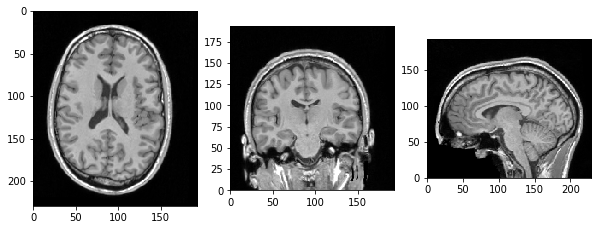

Brain mask


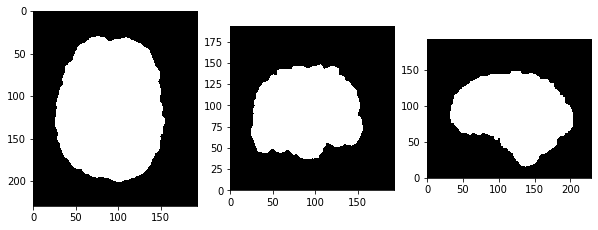

In [6]:
img = sitk.ReadImage(data_dir + 'mri-brain.nii.gz')
msk = sitk.ReadImage(data_dir + 'mri-brain-mask.nii.gz')
print('MR image')
display_image(img, window=400, level=200)
print('Brain mask')
display_image(msk)

use the brain mask to mask out non-brain regions by setting them to zero

Masked image


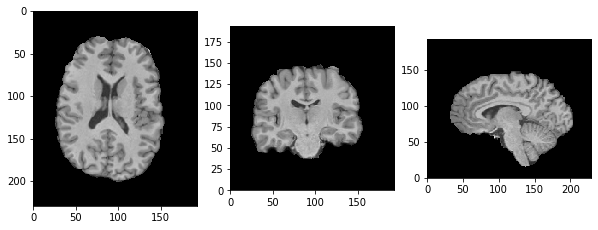

In [7]:
img_array = sitk.GetArrayFromImage(img)
msk_array = sitk.GetArrayFromImage(msk)

masked_array = img_array
masked_array[msk_array==0] = 0

img_masked = sitk.GetImageFromArray(masked_array)
img_masked.CopyInformation(img)

print('Masked image')
display_image(img_masked, window=400, level=200)

## Data preparation for clustering

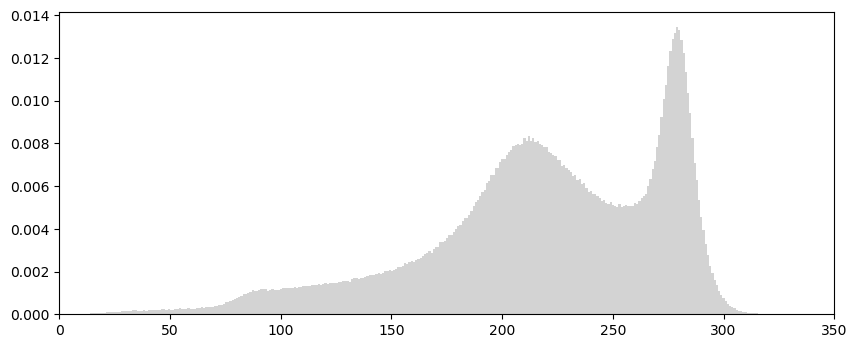

Number of points 1418157


In [8]:
# Take all non-zero voxels and flatten the data into a 1D numpy array
X = img_array[msk_array > 0].flatten().reshape(-1, 1)

# Get the number of points
num_pts = len(X.flatten())

# Extract the minimum and maximum intensity values and calculate the number of bins for the histogram
lim_low = np.min(X).astype(np.int)
lim_high = np.max(X).astype(np.int)
num_bins = (lim_high - lim_low + 1)

plt.figure(figsize=(10, 4), dpi=100)
plt.hist(X, bins=num_bins, density=True, range=(lim_low, lim_high), color='lightgray');
plt.xlim([0,350]);
plt.show()

print('Number of points ' + str(num_pts))

## Random subsampling

use a random subset of the original data for efficiency.

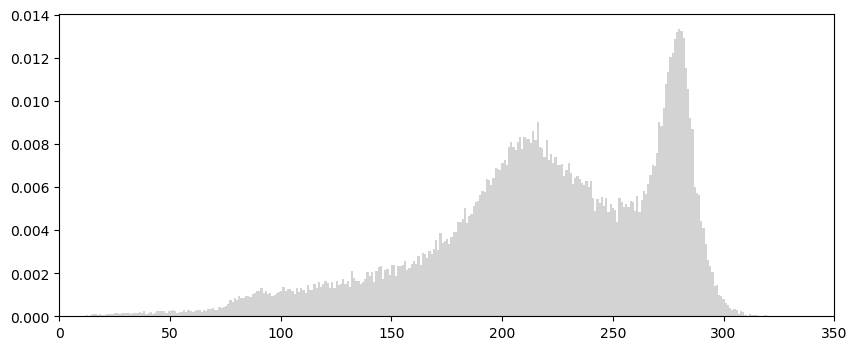

Number of points 70907


In [9]:
sampling = 0.05
X_subset = np.random.choice(X.flatten(),int(num_pts*sampling)).reshape(-1, 1)

plt.figure(figsize=(10, 4), dpi=100)
plt.hist(X_subset, bins=num_bins, density=True, range=(lim_low, lim_high), color='lightgray');
plt.xlim([0,350]);
plt.show()

print('Number of points ' + str(len(X_subset)))

## Number of clusters

Assume the brain consists of mostly three tissue types, grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF).

In [10]:
num_clusters = 3

## K-means

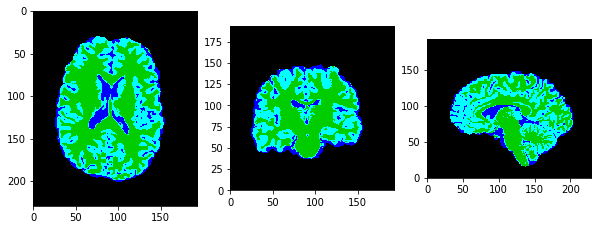

In [11]:
import sklearn.cluster as cluster

# Create a k-means instance
kmeans = cluster.KMeans(n_clusters=num_clusters)

# Running k-means via the fit function
kmeans.fit(X_subset)

# Produce the clustering result for all image points
y = kmeans.predict(img_array.flatten().reshape(-1, 1))

# K-means will produce labels between 0 and (k-1), we want 0 to be background, so we shift the labels by one
y = y + 1 # shift labels
y[(msk_array == 0).flatten()] = 0 # zero background

# Construct a 3D label map
lab_array = y.reshape(img_array.shape).astype('uint8')
seg_kmeans = sitk.GetImageFromArray(lab_array)
seg_kmeans.CopyInformation(img)

# Display the results using SimpleITK mapping of label maps to colours
display_image(sitk.LabelToRGB(seg_kmeans))

## Gaussian Mixture Models

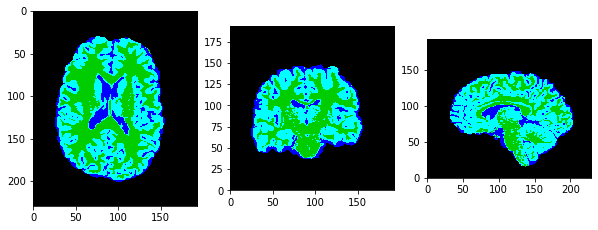

In [14]:
import sklearn.mixture as mixture

# Create a GaussianMixture instance
gmm = mixture.GaussianMixture(n_components=num_clusters)
gmm.fit(X_subset)
y = gmm.predict(img_array.flatten().reshape(-1, 1))
y = y + 1 # shift labels
y[(msk_array == 0).flatten()] = 0 # zero background

lab_array = y.reshape(img_array.shape).astype('uint8')
seg_gmm = sitk.GetImageFromArray(lab_array)
seg_gmm.CopyInformation(img)

display_image(sitk.LabelToRGB(seg_gmm))

### Plotting the GMM result

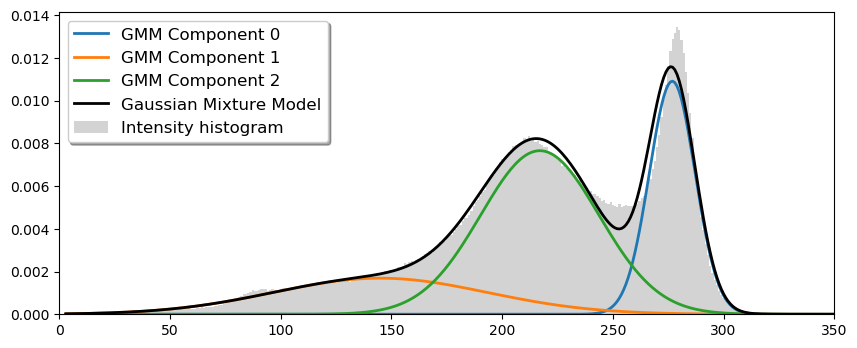

In [16]:
import matplotlib.mlab as mlab
from scipy.stats import norm

def plot_gmm(x, gmm):
    omega = gmm.weights_
    mu = gmm.means_
    sigma = np.sqrt(gmm.covariances_)
    for ind in range(0,omega.shape[0]): 
        plt.plot(x,omega[ind]*norm.pdf(x, mu[ind], sigma[ind]), linewidth=2, label='GMM Component '+str(ind))

plt.figure(figsize=(10, 4), dpi=100)
plt.hist(X, bins=num_bins, density=True, range=(lim_low, lim_high), label='Intensity histogram', color='lightgray');
x = np.linspace(lim_low,lim_high,num_bins).reshape(-1,1)
plot_gmm(x,gmm)
plt.plot(x,np.exp(gmm.score_samples(x)), linewidth=2, color='k', label='Gaussian Mixture Model')
plt.xlim([0,350])
plt.legend(loc=0, shadow=True, fontsize=12)

## Lesion segmentation using clustering

CT image


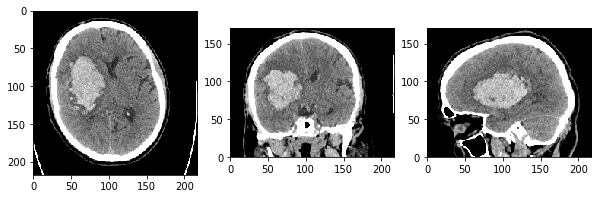

Brain mask


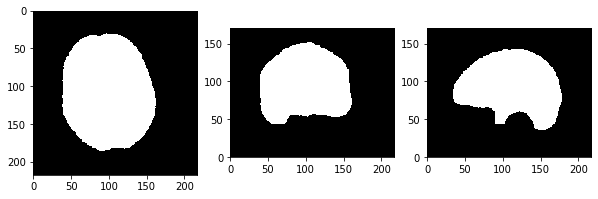

In [18]:
img = sitk.ReadImage(data_dir + 'ct-brain.nii.gz')
msk = sitk.ReadImage(data_dir + 'ct-brain-mask.nii.gz')

print('CT image')
display_image(img, x=70, y=100, z=90, window=120, level=40)

print('Brain mask')
display_image(msk, x=70, y=100, z=90)

Masked image


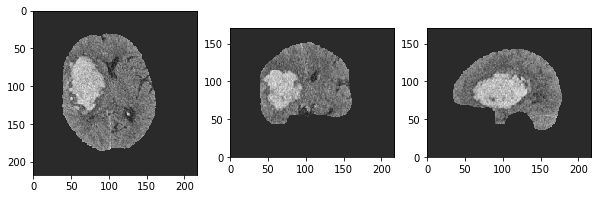

In [19]:
img_array = sitk.GetArrayFromImage(img)
msk_array = sitk.GetArrayFromImage(msk)

masked_array = img_array
masked_array[msk_array==0] = 0

img_masked = sitk.GetImageFromArray(masked_array)
img_masked.CopyInformation(img)

print('Masked image')
display_image(img_masked, x=70, y=100, z=90, window=120, level=40)

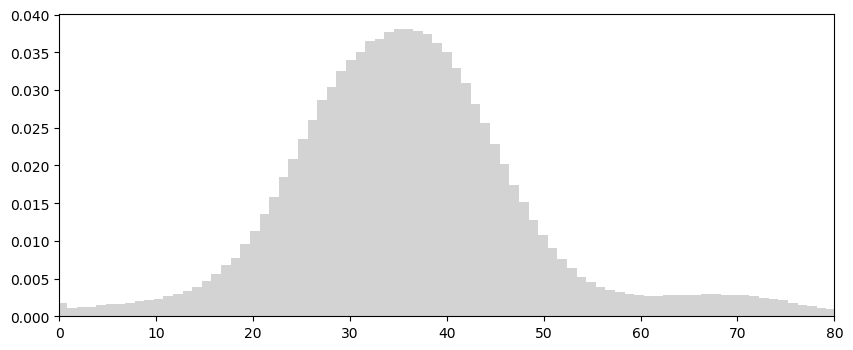

Number of points 1114712


In [20]:
# Take all non-zero voxels and flatten the data into a 1D numpy array
X = img_array[msk_array > 0].flatten().reshape(-1, 1)

# Get the number of points
num_pts = len(X.flatten())

# Extract the minimum and maximum intensity values and calculate the number of bins for the histogram
lim_low = -20 # manually set intensity range of interest
lim_high = 100 # manually set intensity range of interest
num_bins = (lim_high - lim_low + 1)

plt.figure(figsize=(10, 4), dpi=100)
plt.hist(X, bins=num_bins, density=True, range=(lim_low,lim_high), color='lightgray');
plt.xlim([0,80]) # we limit the x-axis to the range of interest
plt.show()

print('Number of points ' + str(num_pts))

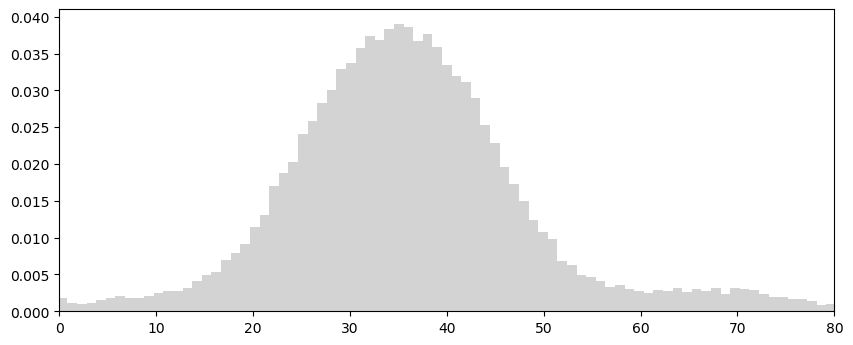

Number of points 55735


In [21]:
sampling = 0.05
X_subset = np.random.choice(X.flatten(),int(num_pts*sampling)).reshape(-1, 1)

plt.figure(figsize=(10, 4), dpi=100)
plt.hist(X_subset, bins=num_bins, density=True, range=(lim_low, lim_high), color='lightgray');
plt.xlim([0,80]);
plt.show()

print('Number of points ' + str(len(X_subset)))

In [22]:
num_clusters = 5

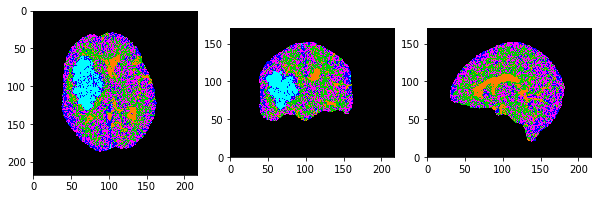

In [23]:
import sklearn.cluster as cluster

# Create a k-means instance
kmeans = cluster.KMeans(n_clusters=num_clusters)

# Running k-means via the fit function
kmeans.fit(X_subset)

# Produce the clustering result for all image points
y = kmeans.predict(img_array.flatten().reshape(-1, 1))

# K-means will produce labels between 0 and (k-1), we want 0 to be background, so we shift the labels by one
y = y + 1 # shift labels
y[(msk_array == 0).flatten()] = 0 # zero background

# Construct a 3D label map
lab_array = y.reshape(img_array.shape).astype('uint8')
seg_kmeans = sitk.GetImageFromArray(lab_array)
seg_kmeans.CopyInformation(img)

# Display the results using SimpleITK mapping of label maps to colours
display_image(sitk.LabelToRGB(seg_kmeans))